This notebook uses matrix-based entropy [1, 2, 3] to look at layer-wise entropies of pretrained LLMs. For an introduction to this, check out the sentence_entropies.ipynb notebook.

Authors: Oscar Skean

In [1]:
%load_ext autoreload
%autoreload 2

from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2LMHeadModel, GPT2Model, AutoModel
import torch
import numpy as np
import tqdm
from utils import get_model_path, get_dataloader, normalize
import repitl.matrix_itl as itl
import repitl.difference_of_entropies as dent
import math

device = "cuda:0"

In [2]:
!pip list

Package                                  Version    Editable project location
---------------------------------------- ---------- ----------------------------------------------------------------------------------
accelerate                               0.31.0
aiohttp                                  3.9.5
aiosignal                                1.3.1
annotated-types                          0.7.0
anyio                                    4.4.0
appdirs                                  1.4.4
asttokens                                2.4.1
async-timeout                            4.0.3
attrs                                    23.2.0
beautifulsoup4                           4.12.3
causal-conv1d                            1.4.0
certifi                                  2024.2.2
charset-normalizer                       3.3.2
click                                    8.1.7
comm                                     0.2.2
contourpy                                1.2.1
cycler                       

# Layerwise Entropies

The information plane is a probe on the model to analyze the mutual information between a pair of variables (input/output, input/layer representation, output/layer representation, etc.) as some quantity is changed (layer depth, context length, etc.).

In [3]:
from utils import compute_LDA_matrix

def entropy_normalization(entropy, normalization, N, D):
    assert normalization in ['maxEntropy', 'logN', 'logD', 'logNlogD', 'raw']

    if normalization == 'maxEntropy':
        entropy /= min(math.log(N), math.log(D))
    elif normalization == 'logN':
        entropy /= math.log(N)
    elif normalization == 'logD':
        entropy /= math.log(D)
    elif normalization == 'logNlogD':
        entropy /= (math.log(N) * math.log(D))
    elif normalization == 'raw':
        pass

    return entropy

def compute_sentence_entropies_over_layers(model, dataloader, alpha=1, normalization='maxEntropy'):
    batched_layerwise_entropy = []
    
    counter = 0
    max_samples = 1000
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, total=max_samples, disable=True):
            counter += 1
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            N, D = outputs.hidden_states[0].shape[1:]

            hidden_states_list = [normalize(x.squeeze()) for x in outputs.hidden_states]

            # get the covariance matrices for each layer outputs
            layer_cov_list = []
            for layer_states in hidden_states_list:
                layer_states = layer_states.squeeze()
                if N > D:
                   layer_cov = layer_states.T @ layer_states
                else:
                    layer_cov = layer_states @ layer_states.T
                layer_cov /= torch.trace(layer_cov)
                layer_cov = torch.clamp(layer_cov, min=0)
                layer_cov_list.append(layer_cov)

            # compute entropy for each covariance
            layerwise_entropies = [itl.matrixAlphaEntropy(X.double(), alpha=alpha).item() for X in layer_cov_list]
            layerwise_entropies = [entropy_normalization(x, normalization, N, D) for x in layerwise_entropies]
            batched_layerwise_entropy.append(layerwise_entropies)

            if counter > max_samples:
                break
    
    avg_layerwise_entropy = np.array(batched_layerwise_entropy).mean(axis=0)
    return avg_layerwise_entropy

def compute_dataset_entropies_over_layers(model, dataloader, alpha=1, normalization='maxEntropy'):
    counter = 0
    max_samples = 1000

    with torch.no_grad():
        layerwise_samples = []
        for batch in tqdm.tqdm(dataloader, total=max_samples, disable=True):
            counter += 1
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            hidden_states_list = [normalize(x.squeeze()) for x in outputs.hidden_states]

            # get mean hidden state for the sample in each layer
            layer_means = [torch.mean(x, dim=0) for x in hidden_states_list]
            layer_means = torch.stack(layer_means)
            layerwise_samples.append(layer_means)

            if counter >= max_samples:
                break

    Z = torch.stack(layerwise_samples)
    Z = Z.transpose(0, 1)
    L, NUM_SAMPLES, D = Z.shape

    if NUM_SAMPLES > D:
        cov = torch.matmul(Z.transpose(1, 2), Z)  # L x D x D
    else:
        cov = torch.matmul(Z, Z.transpose(1, 2))  # L x NUM_SAMPLES x NUM_SAMPLES

    layerwise_entropies = [itl.matrixAlphaEntropy(LAYER_COV.double(), alpha=alpha).item() for LAYER_COV in cov]
    layerwise_entropies = [entropy_normalization(x, normalization, NUM_SAMPLES, D) for x in layerwise_entropies]

    return layerwise_entropies


def compute_dataset_lidar_over_layers(model, dataloader, alpha=1, normalization='maxEntropy', experiment_name='lidar'):        
    counter = 0
    max_samples = 1000

    with torch.no_grad():

        batched_augmented_sample_vectors = []
        for batch in tqdm.tqdm(dataloader, total=max_samples, disable=False):
            counter += 1

            augmented_sample_vectors = []

            for augmented_sample in batch:
                augmented_sample = {k: v.unsqueeze(0).to(device) for k, v in augmented_sample.items()}
                outputs = model(**augmented_sample)

                hidden_states_list = [normalize(x.squeeze()) for x in outputs.hidden_states] # L x N x D

                # get mean hidden state for the sample in each layer
                layer_means = [torch.mean(x, dim=0) for x in hidden_states_list] # L x D
                layer_means = torch.stack(layer_means)
                augmented_sample_vectors.append(layer_means)

            augmented_sample_vectors = torch.stack(augmented_sample_vectors) # NUM_AUGMENTATIONS x L x D
            batched_augmented_sample_vectors.append(augmented_sample_vectors)

            if counter >= max_samples:
                break


    batched_augmented_sample_vectors = torch.stack(batched_augmented_sample_vectors) # NUM_SAMPLES x NUM_AUGMENTATIONS x L x D
    batched_augmented_sample_vectors = batched_augmented_sample_vectors.transpose(0,1).transpose(0,2) # L x NUM_SAMPLES x NUM_AUGMENTATIONS x D 
    L, NUM_SAMPLES, NUM_AUGMENTATIONS, D = batched_augmented_sample_vectors.shape
    
    should_return_within_scatter = True if experiment_name == 'lidar-modified' else False

    layerwise_entropies = [
        itl.matrixAlphaEntropy(
            compute_LDA_matrix(LAYER_EMBEDDINGS.double(), return_within_class_scatter=should_return_within_scatter),
            alpha=alpha
        ).item() 
        for LAYER_EMBEDDINGS in batched_augmented_sample_vectors
    ]
    layerwise_entropies = [entropy_normalization(x, normalization, NUM_SAMPLES, D) for x in layerwise_entropies]

    return layerwise_entropies

def compute_dataset_dime_over_layers(model, dataloader, alpha=1, normalization='maxEntropy'):        
    counter = 0
    max_samples = 1000

    with torch.no_grad():

        batched_augmented_sample_vectors = []
        for batch in tqdm.tqdm(dataloader, total=max_samples, disable=True):
            counter += 1

            augmented_sample_vectors = []
 
            for augmented_sample in batch:
                augmented_sample = {k: v.unsqueeze(0).to(device) for k, v in augmented_sample.items()}
                outputs = model(**augmented_sample)

                hidden_states_list = [normalize(x.squeeze()) for x in outputs.hidden_states] # L x N x D

                # get mean hidden state for the sample in each layer
                layer_means = [torch.mean(x, dim=0) for x in hidden_states_list] # L x D
                layer_means = torch.stack(layer_means)
                augmented_sample_vectors.append(layer_means)

            augmented_sample_vectors = torch.stack(augmented_sample_vectors) # NUM_AUGMENTATIONS x L x D
            batched_augmented_sample_vectors.append(augmented_sample_vectors)

            if counter >= max_samples:
                break


    batched_augmented_sample_vectors = torch.stack(batched_augmented_sample_vectors) # NUM_SAMPLES x NUM_AUGMENTATIONS x L x D
    batched_augmented_sample_vectors = batched_augmented_sample_vectors.transpose(0,1).transpose(0,2).transpose(1,2) # L x NUM_AUGMENTATIONS x NUM_SAMPLES x D 
    L, NUM_SAMPLES, NUM_AUGMENTATIONS, D = batched_augmented_sample_vectors.shape
    
    if NUM_SAMPLES > D:
        layerwise_covariances = torch.matmul(batched_augmented_sample_vectors.transpose(-1, -2), batched_augmented_sample_vectors)  # L x NUM_AUGMENTATIONS x D x D
    else:
        layerwise_covariances = torch.matmul(batched_augmented_sample_vectors, batched_augmented_sample_vectors.transpose(-1, -2))  # L x NUM_AUGMENTATIONS x NUM_SAMPLES x NUM_SAMPLES

    layerwise_dimes = [
        dent.doe(
            LAYER_COV[0].double(),
            LAYER_COV[1].double(),
            alpha=alpha,
            n_iters=10
        ).item() 
        for LAYER_COV in layerwise_covariances
    ]
    layerwise_dimes = [entropy_normalization(x, normalization, NUM_SAMPLES, D) for x in layerwise_dimes]

    return layerwise_dimes

def calculate_paired_curvature(a, b):
    # these vectors should already have unit norm
    return torch.arccos(a.T @ b).item()


def calculate_layer_average_k_curvature(layer_p_embeddings, k=1):
    summation, counter = 0, 0

    while (counter+k) < layer_p_embeddings.shape[0]:
        summation += calculate_paired_curvature(layer_p_embeddings[counter,:], layer_p_embeddings[counter+k,:])
        counter += 1

    summation /= counter
    return summation

def calculate_model_k_curvature(model, dataloader, k=1):
    curvature_list = []
    counter = 0
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, total=100):
            counter+=1
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            N, D = outputs.hidden_states[0].shape[1:]


            layer_embeddings_list = [normalize(x.squeeze()) for x in outputs.hidden_states[1:]]
            layer_curvatures = [calculate_layer_average_k_curvature(layer_p, k=k)/math.log(D) for layer_p in layer_embeddings_list]
            curvature_list.append(layer_curvatures)

            if counter>100:
                break

    return np.array(calculate_model_k_curvature(model, dataloader, k=k)).mean(axis=0)

In [4]:
from utils import model_name_to_sizes, get_augmentation_collated_dataloader
import pickle

def calculate_and_save_layerwise_entropies(model_name, experiment_name, granularity='sentence', alpha=1, normalization='maxEntropy'):
    assert experiment_name in ['alpha1', 'lidar', 'lidar-modified', 'dime', 'curvature']
    assert granularity in ['sentence', 'dataset']

    if 'lidar' in experiment_name or 'dime' in experiment_name:
        assert granularity == 'dataset'
    if 'curvature' in experiment_name:
        assert granularity == 'sentence'

    layerwise_entropies_per_model = {}
    for model_size in model_name_to_sizes[model_name]:
        print('\t Computing entropies for model size:', model_size)
        model_path = get_model_path(model_name, model_size)
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModel.from_pretrained(model_path, output_hidden_states=True, torch_dtype=torch.bfloat16).to(device)

        if granularity == 'sentence' and experiment_name == 'alpha1':
            dataloader = get_dataloader(tokenizer, "wikitext", split="train")
            layerwise_entropies_per_model[model_size] = compute_sentence_entropies_over_layers(model, dataloader, alpha=alpha, normalization=normalization)
        elif granularity == 'dataset' and experiment_name == 'alpha1':
            dataloader = get_dataloader(tokenizer, "wikitext", split="train")
            layerwise_entropies_per_model[model_size] = compute_dataset_entropies_over_layers(model, dataloader, alpha=alpha, normalization=normalization)
        elif granularity == 'dataset' and 'lidar' in experiment_name:
            dataloader = get_augmentation_collated_dataloader(tokenizer, "wikitext", split="train", num_augmentations_per_sample=16)
            layerwise_entropies_per_model[model_size] = compute_dataset_lidar_over_layers(model, dataloader, alpha=alpha, normalization=normalization, experiment_name=experiment_name)
        elif granularity == 'dataset' and 'dime' in experiment_name:
            dataloader = get_augmentation_collated_dataloader(tokenizer, "wikitext", split="train", num_augmentations_per_sample=2)
            layerwise_entropies_per_model[model_size] = compute_dataset_dime_over_layers(model, dataloader, alpha=alpha, normalization=normalization)
        elif experiment_name == 'curvature':
            dataloader = get_dataloader(tokenizer, "wikitext", split="train")
            layerwise_entropies_per_model[model_size] = calculate_model_k_curvature(model, dataloader, k=1)
        del model
    
    with open(f"entropy_results/entropy={experiment_name}_model={model_name}_granularity={granularity}_normalization={normalization}.pkl", "wb") as f:
        pickle.dump(layerwise_entropies_per_model, f)

    return layerwise_entropies_per_model

def load_results_layerwise_entropies(model_name, experiment_name, granularity, normalization):
    with open(f"entropy_results/entropy={experiment_name}_model={model_name}_granularity={granularity}_normalization={normalization}.pkl", "rb") as f:
        layerwise_entropies_per_model = pickle.load(f)
    return layerwise_entropies_per_model

In [5]:
#for model in ['EleutherAI', 'cerebras', 'mamba', 'mamba2']:
for model in ['mamba', 'EleutherAI']:
    for experiment in ['dime', 'lidar']:
        for granularity in ['dataset']:
            for normalization in ['maxEntropy']:
                try:
                    # check if already computed
                    try:
                        load_results_layerwise_entropies(model, experiment, granularity, normalization)
                        print(f"Already computed {model} {experiment} {granularity} {normalization}")
                        continue
                    except:
                        print(f"Computing {model} {experiment} {granularity} {normalization}")
                        calculate_and_save_layerwise_entropies(model, experiment, granularity, alpha=1, normalization=normalization)
                except Exception as e:
                    print(f"Error for {model} {experiment} {granularity} {normalization}")
                    print(e)

Already computed mamba dime dataset maxEntropy
Computing mamba lidar dataset maxEntropy
	 Computing entropies for model size: 130m


/home/AD/ofsk222/miniconda3/envs/information_plane/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|█████████▉| 999/1000 [02:40<00:00,  6.21it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


	 Computing entropies for model size: 370m


100%|█████████▉| 999/1000 [05:13<00:00,  3.19it/s]


	 Computing entropies for model size: 790m


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|█████████▉| 999/1000 [05:23<00:00,  3.08it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


	 Computing entropies for model size: 1.4b


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

 42%|████▏     | 424/1000 [02:17<03:04,  3.11it/s]

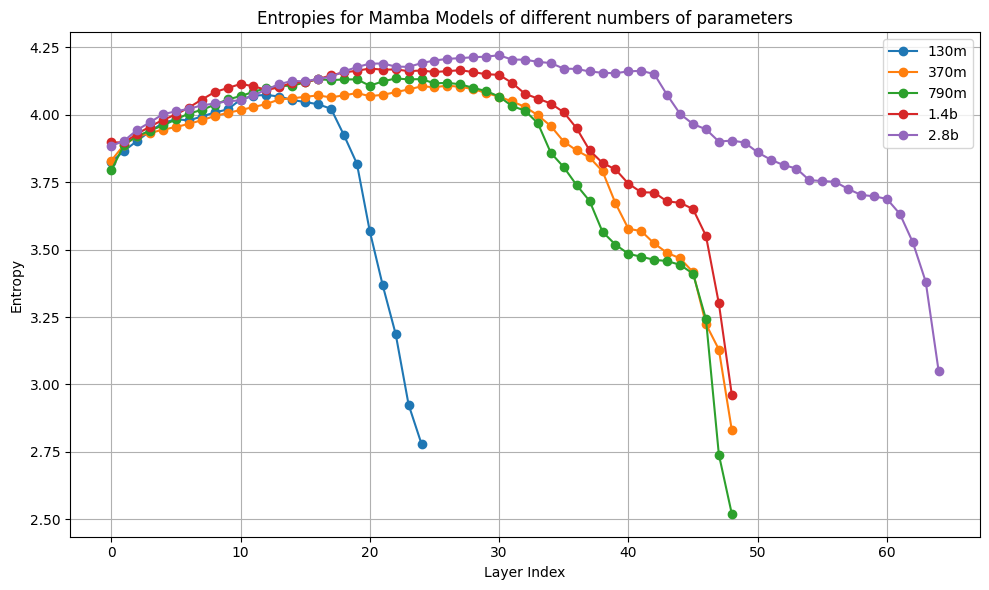

In [ ]:
import matplotlib.pyplot as plt

layerwise_entropies = load_results_layerwise_entropies("mamba", 'alpha1', granularity='sentence', normalization='raw')

fig, ax = plt.subplots(figsize=(10, 6))

for model_name, entropies in layerwise_entropies.items():
    ax.plot(entropies, marker='o', label=model_name)

ax.set_title('Entropies for Mamba Models of different numbers of parameters')
ax.set_xlabel('Layer Index')
ax.set_ylabel('Entropy')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

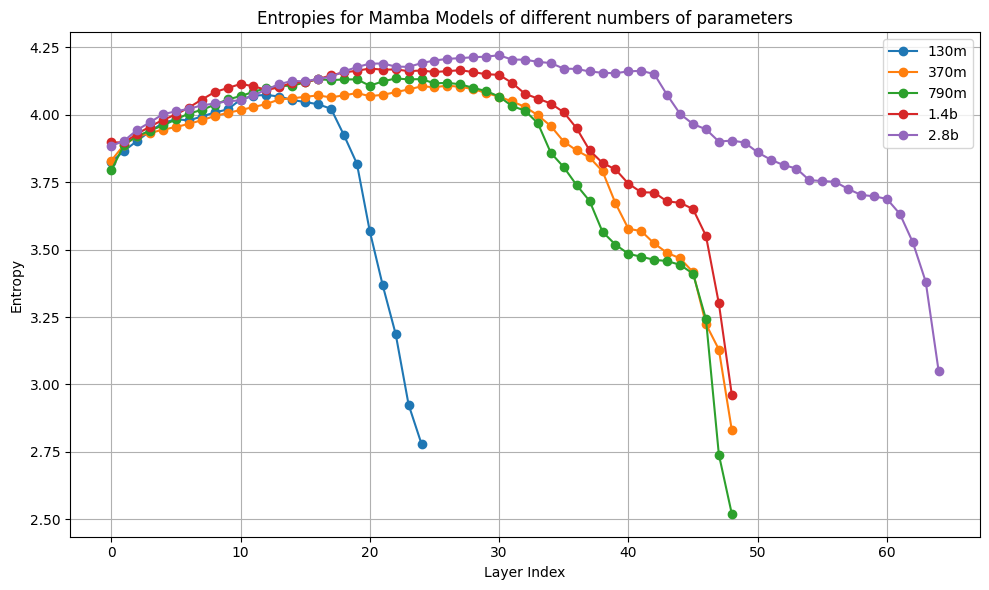

In [ ]:
import matplotlib.pyplot as plt

layerwise_entropies = load_results_layerwise_entropies("mamba", 'alpha1', granularity='sentence', normalization='raw')

fig, ax = plt.subplots(figsize=(10, 6))

for model_name, entropies in layerwise_entropies.items():
    ax.plot(entropies, marker='o', label=model_name)

ax.set_title('Entropies for Mamba Models of different numbers of parameters')
ax.set_xlabel('Layer Index')
ax.set_ylabel('Entropy')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

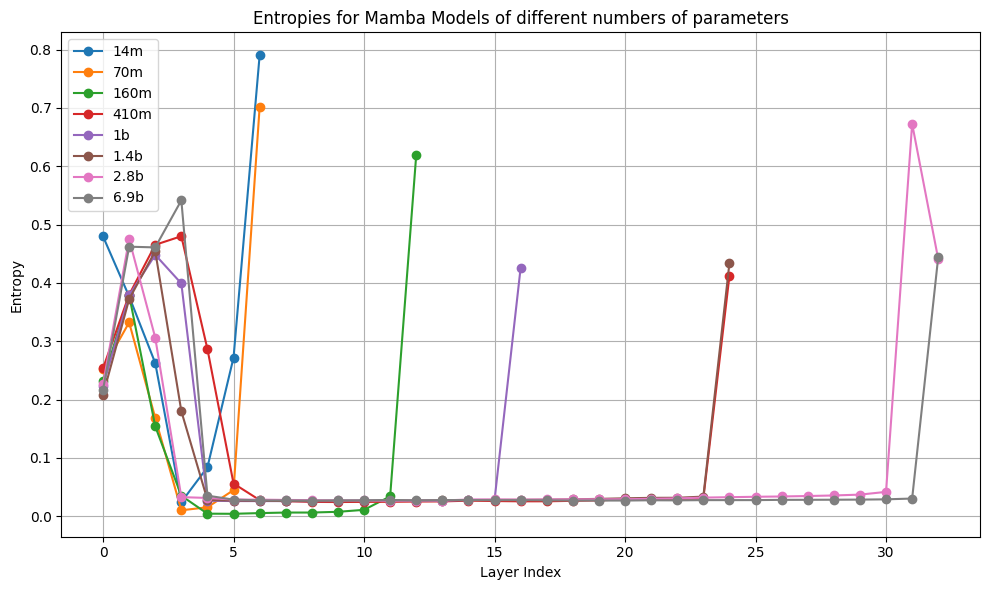

In [ ]:
import matplotlib.pyplot as plt

layerwise_entropies = load_results_layerwise_entropies("EleutherAI", 'alpha1', granularity='dataset', normalization='maxEntropy')

fig, ax = plt.subplots(figsize=(10, 6))

for model_name, entropies in layerwise_entropies.items():
    ax.plot(entropies, marker='o', label=model_name)

ax.set_title('Entropies for Mamba Models of different numbers of parameters')
ax.set_xlabel('Layer Index')
ax.set_ylabel('Entropy')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with a subplot for each model
num_models = len(layerwise_entropies_per_model)
fig, axs = plt.subplots(num_models, 1, figsize=(8, 3 * num_models), sharex=True)

all_entropies = [entropy for entropies in layerwise_entropies_per_model.values() for entropy in entropies]
y_min, y_max = min(all_entropies), max(all_entropies)

# Flatten axs if there is only one subplot
if num_models == 1:
    axs = [axs]

# Plot each model's data
for ax, (model_name, entropies) in zip(axs, layerwise_entropies_per_model.items()):
    ax.plot(entropies, marker='o')
    ax.set_title(f'Entropies for {model_name}')
    ax.set_ylabel('Entropy')
    ax.set_ylim(y_min*0.95, y_max*1.05)
    ax.grid(True)

# Set common x-axis label
axs[-1].set_xlabel('Layer Index')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

NameError: name 'layerwise_entropies_per_model' is not defined

## Data Augmentation

In [1]:
from utils import text_augmentation

input_text = ["The quick brown fox jumps over the lazy dog."]

augmented_text = text_augmentation(input_text, num_augmentations_per_sample=10)
print(f"Original text: {input_text}")
for i, t in enumerate(augmented_text[0].split(',')):
    print(f"Augmented text {i}: {t}")

Original text: ['The quick brown fox jumps over the lazy dog.']
Augmented text 0: ['The q 8ecU b rfBg fox j uHem oSe! the lQz5 dog.'
Augmented text 1:  'The qu ick b Co#p fox P*mks o ver the gFzH dog.'
Augmented text 2:  'The qGiBI HUo3n fox jum ps o ver the la zy dog.'
Augmented text 3:  'The q uJ)Q bro wn fox ju mps oF2$ the l1x0 dog.'
Augmented text 4:  'The q&Jfk b r + wz fox jum ps o ver the lSay dog.'
Augmented text 5:  'The q V&cd br own fox jum ps Xve # the & az (dog.'
Augmented text 6:  'The qu ick bAoQS fox jum ps * vea the la zy dog.'
Augmented text 7:  'The qu ick b & 2wn fox jxbpx dcwr the la zy dog.'
Augmented text 8:  'The q u @ zk b # dwn fox j f<pd ov er the T0ay dog.'
Augmented text 9:  'The !uZXf bro wn fox jum ps M7eF the l azy dog.']


# Plotting

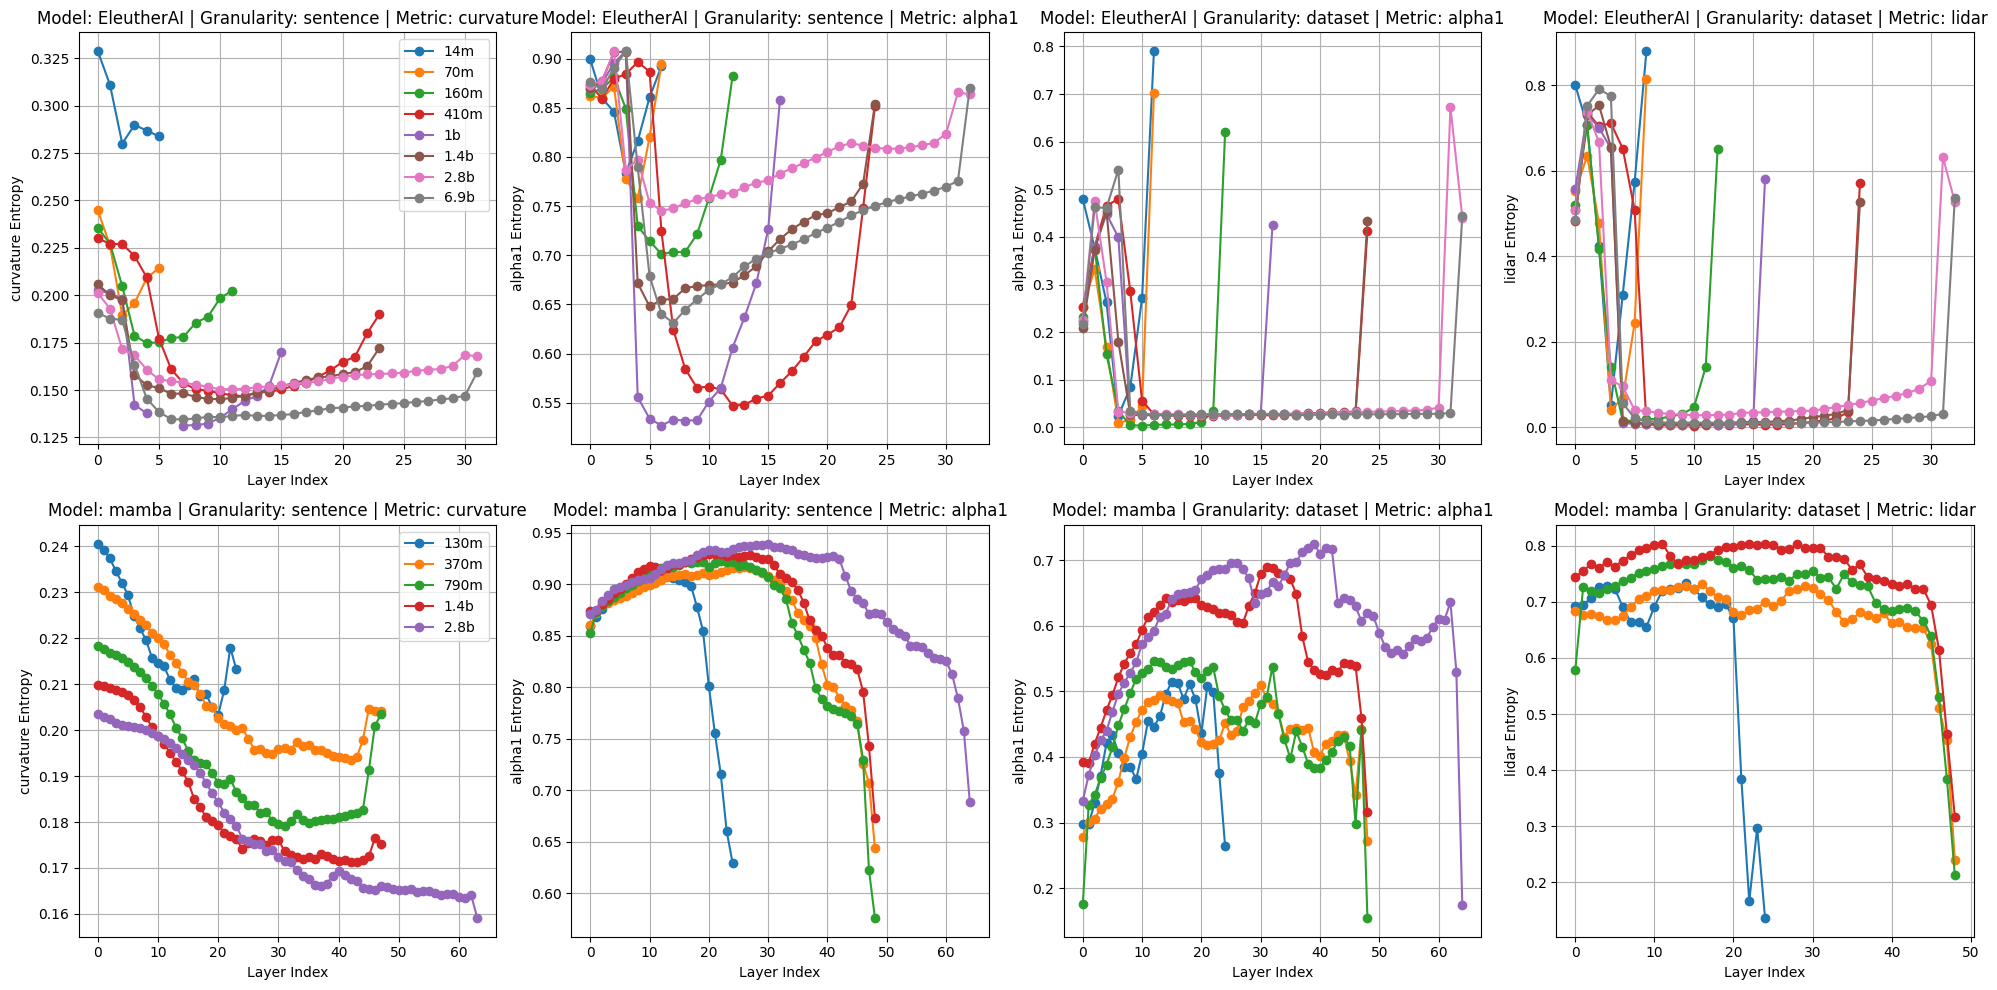

In [8]:
import matplotlib.pyplot as plt
import pickle

def load_results_layerwise_entropies(model_name, experiment_name, granularity, normalization):
    with open(f"entropy_results/entropy={experiment_name}_model={model_name}_granularity={granularity}_normalization={normalization}.pkl", "rb") as f:
        layerwise_entropies_per_model = pickle.load(f)
    return layerwise_entropies_per_model

models = ["EleutherAI", "mamba"]  # Add your models here
#experiments = ["alpha1", "lidar", "dime"]  # Add your experiments here
experiments = ["curvature", "alpha1", "alpha1", "lidar"]  # Add your experiments here

# Create the grid of subplots
A = len(models)
B = len(experiments)
fig, axs = plt.subplots(A, B, figsize=(5 * B, 5 * A))

# Iterate over models and experiments
for i, model_name in enumerate(models):
    for j, experiment_name in enumerate(experiments):
        # Load entropies for each model and experiment
        granularity = 'sentence' if 'alpha1' in experiment_name and j==1 else 'dataset'
        granularity = 'sentence' if 'curvature' in experiment_name else granularity

        normalization = 'maxEntropy'
        normalization = 'raw' if 'curvature' in experiment_name else normalization

        try:
            layerwise_entropies = load_results_layerwise_entropies(model_name, experiment_name, granularity=granularity, normalization=normalization)
        except FileNotFoundError as e:
            print(e)
            layerwise_entropies=None

        # Access the corresponding subplot
        ax = axs[i, j] if A > 1 and B > 1 else axs[j] if A == 1 else axs[i]

        if layerwise_entropies is not None:
            for model_variant, entropies in layerwise_entropies.items():
                ax.plot(entropies, marker='o', label=model_variant)
            ax.set_title(f'Model: {model_name} | Experiment: {experiment_name}')
        else:
            ax.text(0.5, 0.5, 'Missing data', ha='center', va='center', fontsize=12, color='red')
            ax.set_title(f'Model: {model_name} | Experiment: {experiment_name} (Missing)')


        # Set the title and labels
        ax.set_title(f'Model: {model_name} | Granularity: {granularity} | Metric: {experiment_name}')
        ax.set_xlabel('Layer Index')
        ax.set_ylabel(f'{experiment_name} Entropy')
        if j==0:
            ax.legend()
        ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()